In [25]:
# coding:utf8
import requests, json
import pandas as pd
import matplotlib.pyplot as plt
import time
import requests
%matplotlib inline
plt.rcParams["font.family"] = 'Arial Unicode MS'

In [26]:
# 获取输入的股票信息
def get_stock_with_input():
    code_name = input("输入查询的股票名称或代码，如'万华化学'、'600309'：")
    stock_code = ''
    stock_name = ''
    if code_name == '':
        print('不能查空哟！！！')
    else:
        # 查询股票
        code = search_stock(code_name)
        if code is not None:
            # 获取北上资金近100日数据
            stock_code,marketType = assemble_stock_code(code)
            north_arr = get_north_with_stock_code(stock_code,marketType)
            # 画图
            draw_north_price(north_arr)

In [27]:
# 查询股票
def search_stock(input_word):
    time_stamp = int(time.time() * 1000 )
    url = 'http://searchapi.eastmoney.com/api/suggest/get?input={}&type=14&token=D43BF722C8E33BDC906FB84D85E326E8&markettype=&mktnum=&jys=&classify=&securitytype=1,2,6,19,25&count=5&_={}'.format(input_word, time_stamp)

    response = requests.get(url=url)
    if response.status_code == 200:
        response_json = response.json()
        if response_json['QuotationCodeTable'] is not None:
            codes = response_json['QuotationCodeTable']['Data']
            if codes is not list or len(codes)==0:
                codes = list(filter(lambda code: code['Classify'] == 'AStock', codes))
                if len(codes) == 0:
                    print('未查到相关A股上市公司！')
                elif len(codes) > 0:
                    print('lucky！查到A股相关公司{}家！'.format(len(codes)))
                    if len(codes) == 1:
                        return codes[0]
                    else:
                        [print('下标{},{},{}'.format(i,codes[i]['Name'],codes[i]['ID'])) for i in range(len(codes))]
                        code_index = input('请输入查询个股的下标:')
                        if code_index.strip() != '':
                            return codes[int(code_index)]
            else:
                print('未查到相关A股上市公司！')
        else:
            print('未查到相关A股上市公司！')


In [28]:
# 
def assemble_stock_code(stock):
    marketType = stock['MarketType']
    stock_code = stock['Code']

    if marketType == '1':
        marketType = '001'
        stock_code += '.SH'
    elif marketType == '2':
        marketType = '003'
        stock_code += '.SZ'

    return stock_code,marketType

In [29]:
# 获取相关北上数据
def get_north_with_stock_code(stock_code,marketType):
    MUTUAL_TYPE = marketType
    url = 'https://datacenter.eastmoney.com/securities/api/data/get?type=RPT_MUTUAL_STOCK_HOLDRANKN&sty=SECURITY_CODE,SECUCODE,SECURITY_NAME,TRADE_DATE,IS_ADJ_DATE,HOLD_MARKET_CAP,HOLD_SHARES,FREE_SHARES_RATIO,TOTAL_SHARES_RATIO,PARTICIPANT_NUM,ADD_MARKET_CAP,ADD_SHARES_REPAIR,ADD_SHARES_AMP,CLOSE_PRICE,CHANGE_RATE,MUTUAL_TYPE&callback=&extraCols=&filter=(INTERVAL_TYPE="1")(MUTUAL_TYPE="{}")(SECUCODE="{}")&p=1&ps=100&sr=-1&st=TRADE_DATE&token=&var=&source=DataCenter&client=APP'.format(MUTUAL_TYPE,stock_code)

    response = requests.get(url)
    if response.status_code == 200:
        response_json = response.json()
        if response_json['success'] is True:
            return response_json['result']['data']
    else:
        print('数据请求失败，请重试.')


In [30]:
# 绘制收盘价与北上资金折线图
from mpl_toolkits.axes_grid1 import host_subplot

def draw_north_price(north_arr):
    if north_arr is None:
        return
    north_arr = reversed(north_arr)
    df = pd.DataFrame(north_arr)
    # 替换日期字符串为索引
    trade_date_df = df['TRADE_DATE']
    date_indexs = [pd.Timestamp(i) for i in trade_date_df]
    df['TRADE_DATE'] = date_indexs

    stock_name = df['SECURITY_NAME'][0]
    
    # 画图
    # 持仓占流通股本比
    host = host_subplot(111)
    par = host.twinx()

    plt.title(stock_name)
    host.set_ylabel("股价")
    par.set_ylabel("北上持仓占总股本比%")

    p1, = host.plot(df['TRADE_DATE'], df['CLOSE_PRICE'], label="股价")
    p2, = par.plot(df['TRADE_DATE'], df['FREE_SHARES_RATIO'], label="北上持仓占总股本比%")

    leg = plt.legend()

    host.yaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.yaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.show()

lucky！查到A股相关公司1家！


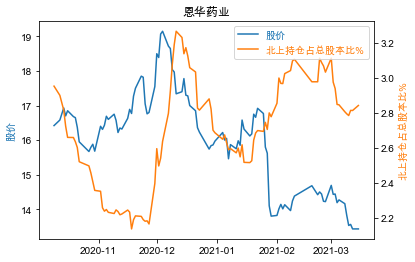

In [34]:
get_stock_with_input()